In [2]:
%load_ext autoreload
%autoreload 2
main_dir = r'../../..'
data_path = main_dir+'/data'
import sys
sys.path.append(main_dir)
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union

from BayDS.lib.pipeline import *
from BayDS.lib.io import *
import os


In [5]:
data_dir = f'e:/kaggle/05-LabelEncoded-last'
p = Pipeline(working_folder=f'{main_dir}/Snapshots/1/catboost_last_dynamics')

p.add_node(LoaderNode, None, 'data',
           params={
               'input_directory': data_dir,
               'file': 'label_encoded_data.pkl'
           })
p.add_node(LoaderNode, None, 'oof',
           params={
               'input_directory': main_dir+'/data/sub',
               'file': 'oof_catboost_last.csv'
           })
p.add_node(LoaderNode, None, 'predictions',
           params={
               'input_directory': main_dir+'/data/sub',
               'file': 'prediction_catboost_last.csv'
           })
p.run(verbose=True)
p.save()

---------------------------
0: LoaderNode [2019-09-30 19:25:03]
params:
 {'input_directory': 'e:/kaggle/05-LabelEncoded-last', 'file': 'label_encoded_data.pkl'}
---------------------------
1: LoaderNode [2019-09-30 19:25:18]
params:
 {'input_directory': '../../../data/sub', 'file': 'oof_catboost_last.csv'}
---------------------------
2: LoaderNode [2019-09-30 19:25:19]
params:
 {'input_directory': '../../../data/sub', 'file': 'prediction_catboost_last.csv'}


In [6]:
df = p.data['data']
df = df[['isFraud', 'new_card_id']]

In [7]:
pred = pd.concat([p.data['oof'].set_index('TransactionID')['isFraud'],p.data['predictions'].set_index('TransactionID')['isFraud']],axis=0)#
pred.index

Int64Index([2987000, 2987001, 2987002, 2987003, 2987004, 2987005, 2987006,
            2987007, 2987008, 2987009,
            ...
            4170230, 4170231, 4170232, 4170233, 4170234, 4170235, 4170236,
            4170237, 4170238, 4170239],
           dtype='int64', name='TransactionID', length=1097231)

In [8]:
pred

TransactionID
2987000    0.012139
2987001    0.004310
2987002    0.001031
2987003    0.001330
2987004    0.001785
             ...   
4170235    0.006686
4170236    0.004775
4170237    0.006381
4170238    0.008974
4170239    0.003817
Name: isFraud, Length: 1097231, dtype: float64

In [9]:
df['pred_0'] = pred

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
df

,isFraud,new_card_id,pred_0
TransactionID,,,
2987000,0,121195,0.012139
2987001,0,137,0.004310
2987002,0,105,0.001031
2987003,0,531,0.001330
2987004,0,9072,0.001785
...,...,...,...
4170235,-1,25,0.006686
4170236,-1,32220,0.004775
4170237,-1,152,0.006381


In [11]:
test = df[['pred_0','new_card_id']].groupby('new_card_id').shift()

In [12]:
shifts = {}
for shift in range(-20,20):
    s = df[['pred_0','new_card_id']].groupby('new_card_id').shift(shift)['pred_0']
    shifts[shift] = s

In [13]:
for k,v in shifts.items():
    if k!=0:
        df[f'pred_{k}']=v

c:\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
df = df.fillna(-1)

In [15]:
X = df[df.isFraud>=0].drop(['isFraud'],axis=1)
y = df[df.isFraud>=0]['isFraud']
test = df[df.isFraud<0].drop(['isFraud'],axis=1)


In [16]:
X

,new_card_id,pred_0,pred_-20,pred_-19,pred_-18,pred_-17,pred_-16,pred_-15,pred_-14,pred_-13,...,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,121195,0.012139,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987001,137,0.004310,0.009468,0.000580,0.008059,0.002726,0.239885,0.037089,0.048688,0.012265,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987002,105,0.001031,0.002484,0.001514,0.012547,0.006796,0.002858,0.003719,0.004331,0.005900,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987003,531,0.001330,0.000514,0.001352,0.000562,0.003509,0.003266,0.003480,0.000920,0.001296,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987004,9072,0.001785,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.018270,0.005218,0.006016,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535,112861,0.008031,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3577536,17127,0.004768,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3577537,202,0.005185,0.002745,0.544660,0.126975,0.007975,0.004755,0.003642,0.002980,0.019919,...,0.004088,0.003108,0.006066,0.003953,0.005110,0.006451,0.011100,0.011806,0.008951,0.005794


In [17]:
categorical_features = [c for c, col in enumerate(X.columns) if col in ['new_card_id']]


In [18]:
params = {'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.5899927210061127,
          'reg_lambda': 0.8485237330340494,
          'random_state': 47, 
#           'categorical_feature': categorical_features,
         }


In [19]:
from sklearn.model_selection import KFold
n_fold = 5
# folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

In [20]:
from BayDS.lib.training import *

Using TensorFlow backend.
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

Fold 1 started at Mon Sep 30 19:26:32 2019
Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.964609	training's auc: 0.96461	valid_1's auc: 0.93636	valid_1's auc: 0.93638
[200]	training's auc: 0.967758	training's auc: 0.967783	valid_1's auc: 0.936363	valid_1's auc: 0.936367
[300]	training's auc: 0.969503	training's auc: 0.969503	valid_1's auc: 0.936667	valid_1's auc: 0.936671
[400]	training's auc: 0.971208	training's auc: 0.971208	valid_1's auc: 0.936676	valid_1's auc: 0.936675
[500]	training's auc: 0.97269	training's auc: 0.97269	valid_1's auc: 0.936639	valid_1's auc: 0.936636
[600]	training's auc: 0.974051	training's auc: 0.974051	valid_1's auc: 0.936559	valid_1's auc: 0.936557
[700]	training's auc: 0.97537	training's auc: 0.97537	valid_1's auc: 0.936433	valid_1's auc: 0.936435
[800]	training's auc: 0.976641	training's auc: 0.976641	valid_1's auc: 0.936375	valid_1's auc: 0.936377
[900]	training's auc: 0.977814	training's auc: 0.977814	valid_1's au

[800]	training's auc: 0.973666	training's auc: 0.973665	valid_1's auc: 0.958658	valid_1's auc: 0.958657
[900]	training's auc: 0.975145	training's auc: 0.975145	valid_1's auc: 0.95866	valid_1's auc: 0.95866
[1000]	training's auc: 0.976367	training's auc: 0.976368	valid_1's auc: 0.95863	valid_1's auc: 0.95863
[1100]	training's auc: 0.977653	training's auc: 0.977652	valid_1's auc: 0.95856	valid_1's auc: 0.95856
[1200]	training's auc: 0.978677	training's auc: 0.978677	valid_1's auc: 0.958555	valid_1's auc: 0.958555
[1300]	training's auc: 0.979686	training's auc: 0.979686	valid_1's auc: 0.958523	valid_1's auc: 0.958523
[1400]	training's auc: 0.980702	training's auc: 0.980702	valid_1's auc: 0.958488	valid_1's auc: 0.958488
[1500]	training's auc: 0.981707	training's auc: 0.981707	valid_1's auc: 0.958408	valid_1's auc: 0.958407
[1600]	training's auc: 0.982542	training's auc: 0.982542	valid_1's auc: 0.95842	valid_1's auc: 0.95842
Early stopping, best iteration is:
[627]	training's auc: 0.971117

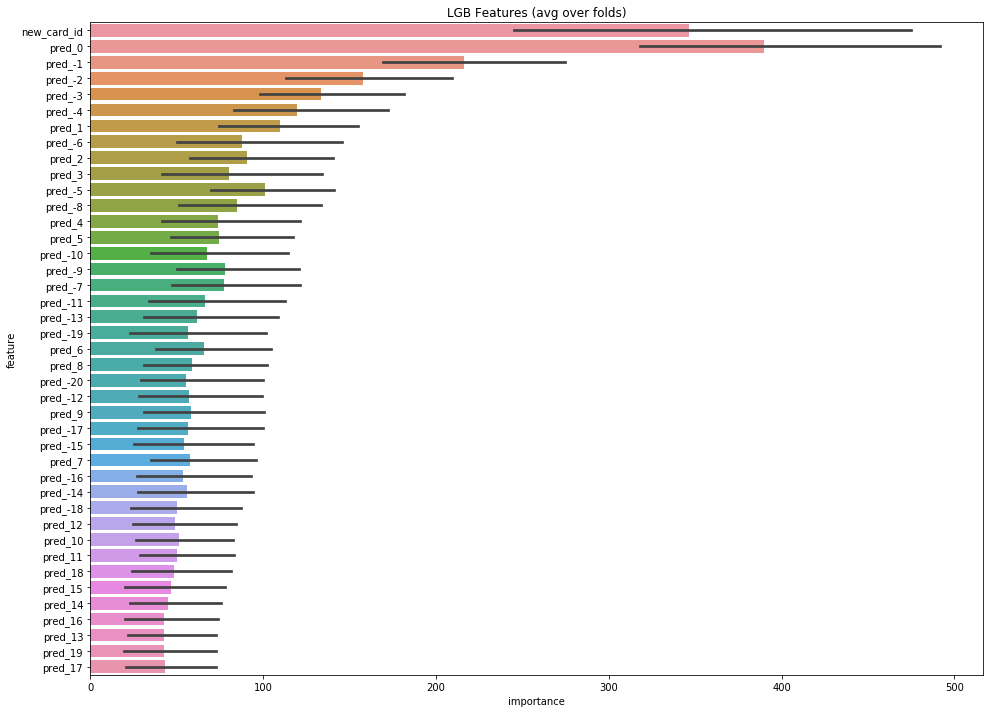

In [21]:
result_dict_lgb = train_model_classification(X=X, X_test=test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=100, early_stopping_rounds=300, n_estimators=5000, averaging='usual', groups=None)

In [22]:
import pickle
pickle.dump(result_dict_lgb, open(f'{p.working_folder}/results_dict_cat_final_20.pkl','wb'))

In [23]:
# test = test.sort_values('Date')
test['prediction'] = result_dict_lgb['prediction']

In [24]:
# folder_path = './data/'
sub = pd.read_csv(f'{data_path}/sample_submission.csv')
sub['isFraud'] = pd.merge(sub, test['prediction'], on='TransactionID')['prediction']
sub.to_csv(f'{p.working_folder}/submission_dynamic_cat_final_20.csv', index=False)